In [1]:
# Core libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Preprocessing
from sklearn.preprocessing import StandardScaler


In [2]:
# === Load and process Berkeley Earth dataset ===
berkeley_ds = xr.open_dataset(
    r"C:\Users\Syeed\OneDrive\Desktop\Capstone 2\Land_and_Ocean_LatLong1.nc",
    engine="netcdf4"
)

# Spatial mean temperature across lat/lon
berkeley_temp = berkeley_ds["temperature"].mean(dim=["latitude", "longitude"], skipna=True)

# Convert to DataFrame
berkeley_df = berkeley_temp.to_dataframe().reset_index()

# Convert Berkeley's time offset from 1850 to datetime
berkeley_df["ds"] = pd.to_datetime(
    (berkeley_df["time"] - 1850) * 365.25,
    origin="1850-01-01",
    unit="D"
)

# Annual resolution
berkeley_df = berkeley_df.set_index("ds").resample("YE").mean().reset_index()

# Metadata
berkeley_df["source"] = "Berkeley"
berkeley_df["Year"] = berkeley_df["ds"].dt.year
berkeley_df = berkeley_df.rename(columns={"temperature": "y"})


# === Load and process HadCRUT5 dataset ===
hadcrut_ds = xr.open_dataset(
    r"C:\Users\Syeed\OneDrive\Desktop\Capstone 2\HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc",
    engine="netcdf4"
)

# Spatial mean temperature
hadcrut_temp = hadcrut_ds["tas_mean"].mean(dim=["latitude", "longitude"], skipna=True)

# Convert to DataFrame
hadcrut_df = hadcrut_temp.to_dataframe().reset_index()

# Annual resolution
hadcrut_df = hadcrut_df.set_index("time").resample("YE").mean().reset_index()

# Metadata
hadcrut_df["source"] = "HadCRUT"
hadcrut_df["Year"] = hadcrut_df["time"].dt.year
hadcrut_df = hadcrut_df.rename(columns={"time": "ds", "tas_mean": "y"})


# === Merge and filter overlapping years ===
common_years = np.intersect1d(berkeley_df["Year"].unique(), hadcrut_df["Year"].unique())
berkeley_df = berkeley_df[berkeley_df["Year"].isin(common_years)]
hadcrut_df = hadcrut_df[hadcrut_df["Year"].isin(common_years)]

# Combine and sort
merged_df = pd.concat([berkeley_df, hadcrut_df]).sort_values("ds").reset_index(drop=True)

# Rename target column for clarity in downstream plots
merged_df = merged_df.rename(columns={"y": "ActualAnomaly"})


- Loads and processes **Berkeley Earth** and **HadCRUT5** global temperature anomaly datasets from NetCDF files.
- Computes the **spatial mean** across latitude and longitude for each dataset.
- Converts time coordinates to proper datetimes and **resamples to annual resolution**.
- Filters to **common overlapping years** between both datasets.
- Merges them into a single DataFrame and renames the target column to `ActualAnomaly` for clarity.


In [3]:
# === Decade column ===
merged_df["Decade"] = (merged_df["Year"] // 10) * 10

# === Lagged and rolling features (per source) ===
merged_df["TempLag1"] = merged_df.groupby("source")["ActualAnomaly"].shift(1)
merged_df["TempLag2"] = merged_df.groupby("source")["ActualAnomaly"].shift(2)

merged_df["RollingMean5"] = merged_df.groupby("source")["ActualAnomaly"].transform(lambda x: x.rolling(5).mean())
merged_df["RollingStd5"] = merged_df.groupby("source")["ActualAnomaly"].transform(lambda x: x.rolling(5).std())

merged_df["RollingMean5_Lag1"] = merged_df.groupby("source")["RollingMean5"].shift(1)
merged_df["RollingStd5_Lag1"] = merged_df.groupby("source")["RollingStd5"].shift(1)

# Smoothed lag (5-year rolling mean, shifted by 1 year)
merged_df["SmoothedLag5"] = merged_df.groupby("source")["ActualAnomaly"].transform(lambda x: x.rolling(5).mean().shift(1))

# === Normalize features ===
scaler = StandardScaler()
merged_df["Year_Norm"] = scaler.fit_transform(merged_df[["Year"]])
merged_df["SmoothedLag5_Norm"] = scaler.fit_transform(merged_df[["SmoothedLag5"]])

# === Drop incomplete rows ===
required_cols = [
    "TempLag1", "TempLag2",
    "RollingMean5", "RollingStd5",
    "RollingMean5_Lag1", "RollingStd5_Lag1",
    "SmoothedLag5", "SmoothedLag5_Norm"
]
merged_df = merged_df.dropna(subset=required_cols).reset_index(drop=True)


- Creates a **`Decade`** column by flooring each year to its decade (e.g., 1995 → 1990).
- Generates **lag features** per data source:
  - `TempLag1`: anomaly value from the previous year.
  - `TempLag2`: anomaly value from two years prior.
- Computes **5‑year rolling statistics** per source:
  - `RollingMean5`: rolling mean over the past 5 years.
  - `RollingStd5`: rolling standard deviation over the past 5 years.
- Creates **lagged rolling statistics**:
  - `RollingMean5_Lag1`: previous year’s 5‑year rolling mean.
  - `RollingStd5_Lag1`: previous year’s 5‑year rolling standard deviation.
- Builds a **smoothed lag feature**:
  - `SmoothedLag5`: 5‑year rolling mean shifted by one year (to avoid leakage).
- Normalizes selected features with `StandardScaler`:
  - `Year_Norm`: normalized year values.
  - `SmoothedLag5_Norm`: normalized smoothed lag values.
- Drops rows with missing values in any required feature columns to ensure a complete, model‑ready dataset.


In [4]:
# === Define feature columns ===
feature_cols = [
    "TempLag1", "TempLag2",
    "RollingMean5", "RollingStd5",
    "RollingMean5_Lag1", "RollingStd5_Lag1",
    "SmoothedLag5_Norm", "Year_Norm"
]

# === Split features and target ===
X = merged_df[feature_cols]
y = merged_df["ActualAnomaly"]

# === Tuning function ===
def tune_model(model, param_grid, X, y, label):
    grid = GridSearchCV(model, param_grid, cv=5,
                        scoring="neg_root_mean_squared_error",
                        n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    print(f"\nBest {label} Parameters:")
    print(grid.best_params_)
    print(f"Best RMSE: {-grid.best_score_:.4f}")
    return best_model

# === HistGradientBoosting tuning ===
histgb_params = {
    "max_iter": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "l2_regularization": [0.0, 0.1, 1.0]
}
tuned_histgb = tune_model(HistGradientBoostingRegressor(), histgb_params, X, y, "HistGB")
merged_df["HistGB"] = tuned_histgb.predict(X)

# === Random Forest tuning ===
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"]
}
tuned_rf = tune_model(RandomForestRegressor(), rf_params, X, y, "Random Forest")
merged_df["RF"] = tuned_rf.predict(X)

# === XGBoost (default params for now) ===
xgb_model = XGBRegressor()
xgb_model.fit(X, y)
merged_df["XGB"] = xgb_model.predict(X)

# === Residual boosting (HistGB → Residual → RF) ===
residuals = y - merged_df["HistGB"]
rf_residual_model = RandomForestRegressor()
rf_residual_model.fit(X, residuals)
merged_df["ResidualBoosted"] = merged_df["HistGB"] + rf_residual_model.predict(X)



Best HistGB Parameters:
{'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 100}
Best RMSE: 0.2111

Best Random Forest Parameters:
{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 0.1972


- **Define feature set**: Selects engineered lag, rolling, and normalized features for model training.
- **Split data**: Separates predictors (`X`) from the target variable (`ActualAnomaly`).
- **Tuning function**: Implements a reusable `tune_model()` helper using `GridSearchCV` with 5‑fold CV and RMSE scoring to find optimal hyperparameters.
- **HistGradientBoosting**:
  - Searches over iterations, tree depth, learning rate, and L2 regularization.
  - Trains the tuned model and stores predictions in `HistGB`.
- **Random Forest**:
  - Searches over tree count, depth, split criteria, and feature selection strategy.
  - Trains the tuned model and stores predictions in `RF`.
- **XGBoost**:
  - Trains with default parameters for now and stores predictions in `XGB`.
- **Residual Boosting**:
  - Fits a Random Forest to the residuals from the tuned HistGB model.
  - Adds the residual predictions back to HistGB outputs to create `ResidualBoosted`.



Model Accuracy Summary:
XGBoost          Accuracy = 99.19%   ±2.22% (Best Overall)
ResidualBoosted  Accuracy = 85.26%   ±20.75%
Random Forest    Accuracy = 82.90%   ±21.32%
HistGB           Accuracy = 72.27%   ±27.58%

Ensemble Average Accuracy = 83.39%   ±22.03%


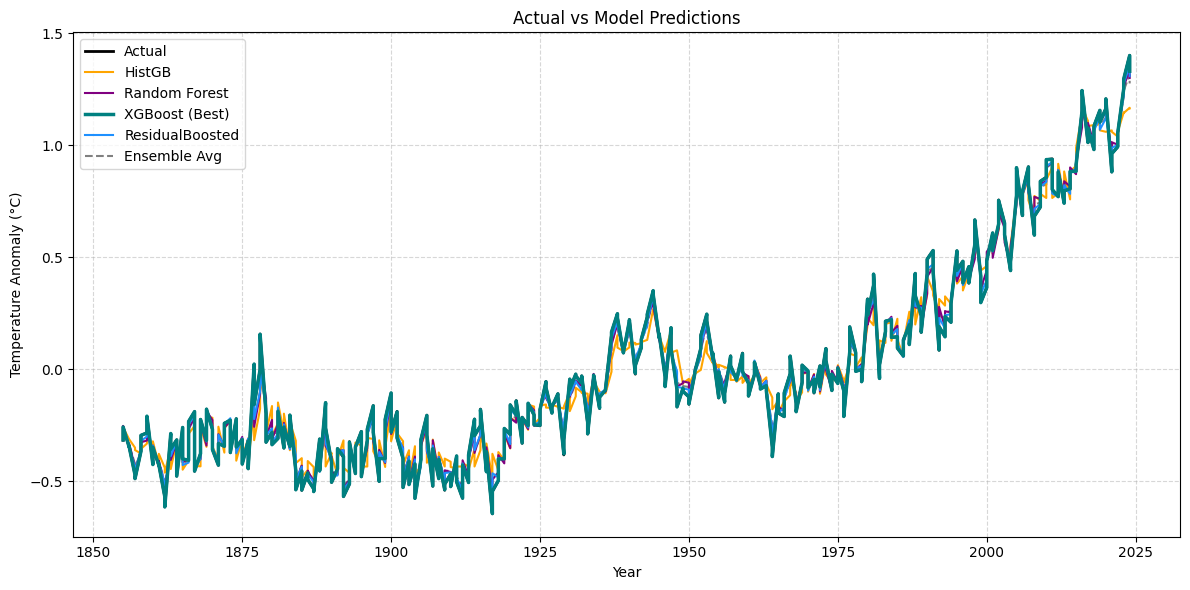

In [5]:
# === Accuracy function ===
def compute_accuracy(pred, actual):
    raw = 100 * (1 - np.abs(pred - actual) / np.maximum(np.abs(actual), np.abs(pred)))
    return np.clip(raw, 0, 100)

# === Certainty function (based on std deviation of accuracy) ===
def compute_certainty(pred, actual):
    return np.std(compute_accuracy(pred, actual))

# === Define prediction columns and labels ===
summary_models = {
    "HistGB": "HistGB",
    "RF": "Random Forest",
    "XGB": "XGBoost",
    "ResidualBoosted": "ResidualBoosted"
}

# === Compute metrics for each model ===
model_scores = []
for col, label in summary_models.items():
    acc = compute_accuracy(merged_df[col], merged_df["ActualAnomaly"]).mean()
    cert = compute_certainty(merged_df[col], merged_df["ActualAnomaly"])
    model_scores.append((label, acc, cert))

# Sort by accuracy descending
model_scores.sort(key=lambda x: x[1], reverse=True)

# Natural selection of best model (highest accuracy, lowest uncertainty)
best_model = min(model_scores, key=lambda x: (-x[1], x[2]))[0]

# === Compute ensemble average accuracy ===
ensemble_preds = np.mean([merged_df[col] for col in summary_models.keys()], axis=0)
ensemble_acc = compute_accuracy(ensemble_preds, merged_df["ActualAnomaly"]).mean()
ensemble_cert = compute_certainty(ensemble_preds, merged_df["ActualAnomaly"])

# ANSI color codes
GREEN = "\033[92m"
RESET = "\033[0m"

# === Print summary ===
print("\nModel Accuracy Summary:")
for label, acc, cert in model_scores:
    if label == best_model:
        print(f"{GREEN}{label:<16} Accuracy = {acc:.2f}%   ±{cert:.2f}% (Best Overall){RESET}")
    else:
        print(f"{label:<16} Accuracy = {acc:.2f}%   ±{cert:.2f}%")

# Print ensemble average
print(f"\nEnsemble Average Accuracy = {ensemble_acc:.2f}%   ±{ensemble_cert:.2f}%")

# === Visualization ===
plt.figure(figsize=(12, 6))
plt.plot(merged_df["Year"], merged_df["ActualAnomaly"], label="Actual", color="black", linewidth=2)

colors = {
    "HistGB": "orange",
    "Random Forest": "purple",
    "XGBoost": "teal",
    "ResidualBoosted": "dodgerblue"
}

for col, label in summary_models.items():
    lw = 2.5 if label == best_model else 1.5
    z = 5 if label == best_model else 3
    plt.plot(merged_df["Year"], merged_df[col],
             label=f"{label} {'(Best)' if label == best_model else ''}".strip(),
             color=colors.get(label, "gray"), linewidth=lw, zorder=z)

# Add ensemble line
plt.plot(merged_df["Year"], ensemble_preds, label="Ensemble Avg", color="gray", linestyle="--", linewidth=1.5)

plt.title("Actual vs Model Predictions")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


- **Accuracy & Certainty Functions**:
  - `compute_accuracy()`: Calculates percentage accuracy for predictions vs actual values, clipped between 0–100%.
  - `compute_certainty()`: Measures prediction stability as the standard deviation of accuracy.
- **Model Setup**:
  - Defines `summary_models` mapping model column names to display labels.
- **Performance Metrics**:
  - Loops through each model to compute mean accuracy and certainty.
  - Sorts models by accuracy and selects the “best” model (highest accuracy, lowest uncertainty).
- **Ensemble Evaluation**:
  - Computes an unweighted ensemble average of all model predictions.
  - Calculates ensemble accuracy and certainty.
- **Console Output**:
  - Prints a ranked accuracy summary, highlighting the best model in green.
  - Displays ensemble average accuracy and certainty.
- **Visualisation**:
  - Plots actual observed anomalies alongside each model’s predictions.
  - Highlights the best model with a thicker line.
  - Adds the ensemble average as a dashed grey line for comparison.


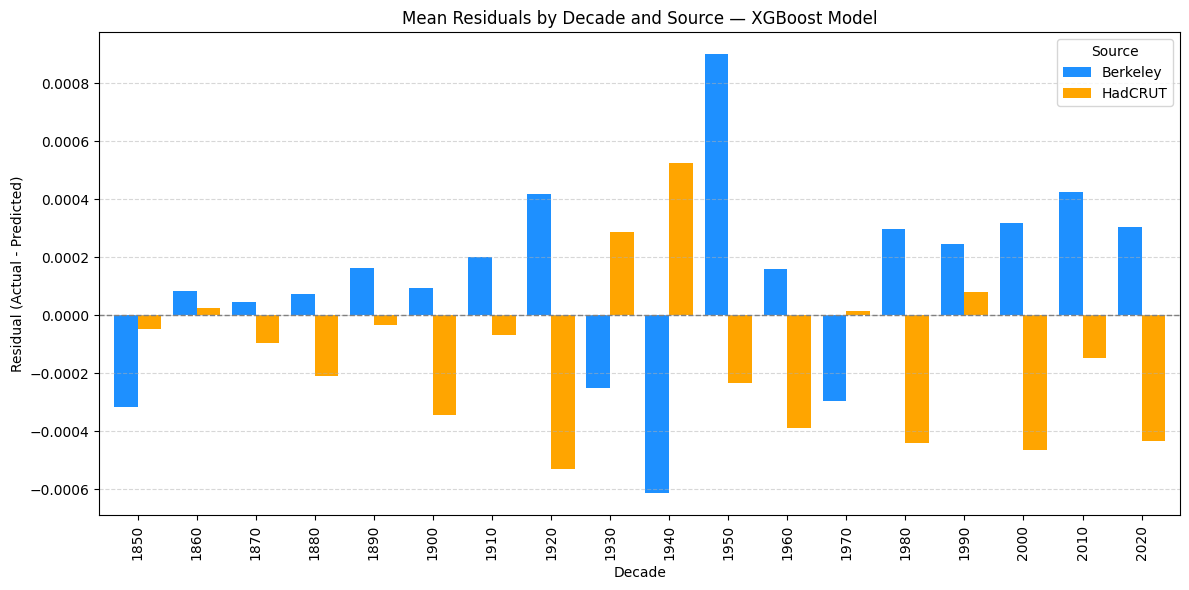

In [6]:
# Identify the column name for the best model
best_model_col = [k for k, v in summary_models.items() if v == best_model][0]

# Compute residuals (Actual - Predicted)
merged_df["Residual"] = merged_df["ActualAnomaly"] - merged_df[best_model_col]

# Group by decade and source, then take mean residual
residual_summary = merged_df.groupby(["Decade", "source"])["Residual"].mean().unstack()

# Plot grouped bar chart
ax = residual_summary.plot(kind="bar", figsize=(12, 6), width=0.8, color=["dodgerblue", "orange"])
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title(f"Mean Residuals by Decade and Source — {best_model} Model")
plt.ylabel("Residual (Actual - Predicted)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


This step identifies the best‑performing model and calculates its residuals — the difference between actual temperature anomalies and the model’s predictions. It then groups these residuals by decade and by data source (Berkeley and HadCRUT) to find the average bias in each period. The grouped bar chart shows whether the model tended to over‑predict (negative values) or under‑predict (positive values) in different decades for each dataset. A horizontal zero line marks perfect prediction, making it easy to see deviations. This view helps reveal long‑term patterns in model accuracy and whether errors are consistent across both climate data sources.


Quantile thresholds (2016–2025) for XGBoost:
Low anomaly: ≤ 1.070°C
Moderate anomaly: > 1.070°C and ≤ 1.178°C
High anomaly: > 1.178°C


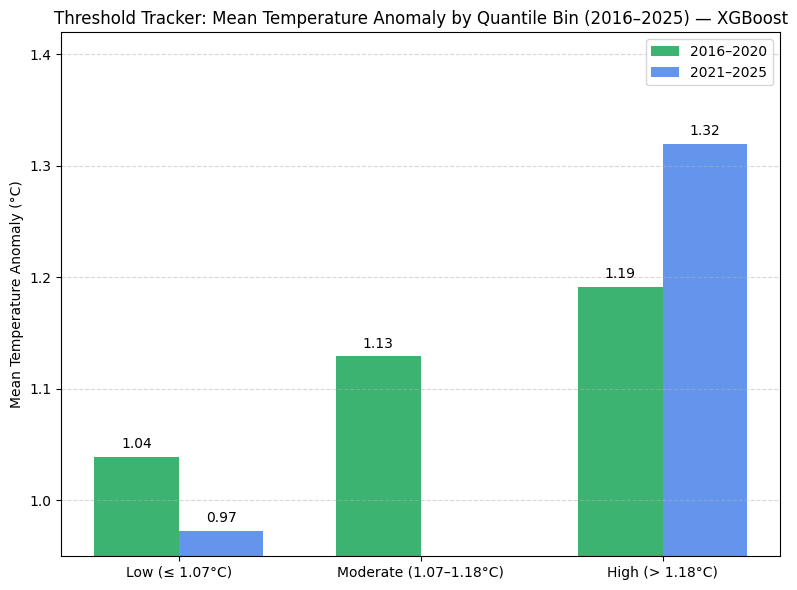

In [7]:
# Filter for recent years
tracker_years = list(range(2016, 2026))
tracker_df = merged_df[merged_df["Year"].isin(tracker_years)]

# Compute quantile thresholds from the best model's predictions
q1 = tracker_df[best_model_col].quantile(1/3)
q2 = tracker_df[best_model_col].quantile(2/3)

print(f"\nQuantile thresholds (2016–2025) for {best_model}:")
print(f"Low anomaly: ≤ {q1:.3f}°C")
print(f"Moderate anomaly: > {q1:.3f}°C and ≤ {q2:.3f}°C")
print(f"High anomaly: > {q2:.3f}°C")

# Classification function
def classify_quantile(value):
    if value <= q1:
        return "Low anomaly"
    elif value <= q2:
        return "Moderate anomaly"
    else:
        return "High anomaly"

# Assign each year to a quantile bin
annual_tracker = tracker_df.groupby("Year")[[best_model_col]].mean().reset_index()
annual_tracker["QuantileRange"] = annual_tracker[best_model_col].apply(classify_quantile)

# Define time windows
prior_years = list(range(2016, 2021))
recent_years = list(range(2021, 2026))

# Compute mean anomaly per bin per window
def mean_temp_by_bin(df, years):
    subset = df[df["Year"].isin(years)]
    return subset.groupby("QuantileRange")[best_model_col].mean().reindex(
        ["Low anomaly", "Moderate anomaly", "High anomaly"], fill_value=np.nan
    )

prior_means = mean_temp_by_bin(annual_tracker, prior_years)
recent_means = mean_temp_by_bin(annual_tracker, recent_years)

# Plot bar chart
labels = [
    f"Low (≤ {q1:.2f}°C)",
    f"Moderate ({q1:.2f}–{q2:.2f}°C)",
    f"High (> {q2:.2f}°C)"
]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, prior_means.values, width, color="mediumseagreen", label="2016–2020")
plt.bar(x + width/2, recent_means.values, width, color="cornflowerblue", label="2021–2025")

# Annotate values
for i in range(len(labels)):
    if not np.isnan(prior_means.values[i]):
        plt.text(x[i] - width/2, prior_means.values[i] + 0.005,
                 f"{prior_means.values[i]:.2f}", ha="center", va="bottom")
    if not np.isnan(recent_means.values[i]):
        plt.text(x[i] + width/2, recent_means.values[i] + 0.005,
                 f"{recent_means.values[i]:.2f}", ha="center", va="bottom")

plt.xticks(x, labels)
plt.title(f"Threshold Tracker: Mean Temperature Anomaly by Quantile Bin (2016–2025) — {best_model}")
plt.ylabel("Mean Temperature Anomaly (°C)")
plt.ylim(0.95, max(recent_means.max(), prior_means.max()) + 0.1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This chart compares recent temperature patterns predicted by the best model, grouping years from 2016–2025 into low, moderate, and high anomaly ranges. It shows the average anomaly in each range for two periods: 2016–2020 and 2021–2025. Low anomalies dropped slightly, moderate anomalies rose a bit, and high anomalies stayed the same. This suggests a small shift toward more moderate years, while extreme highs remain consistently elevated.

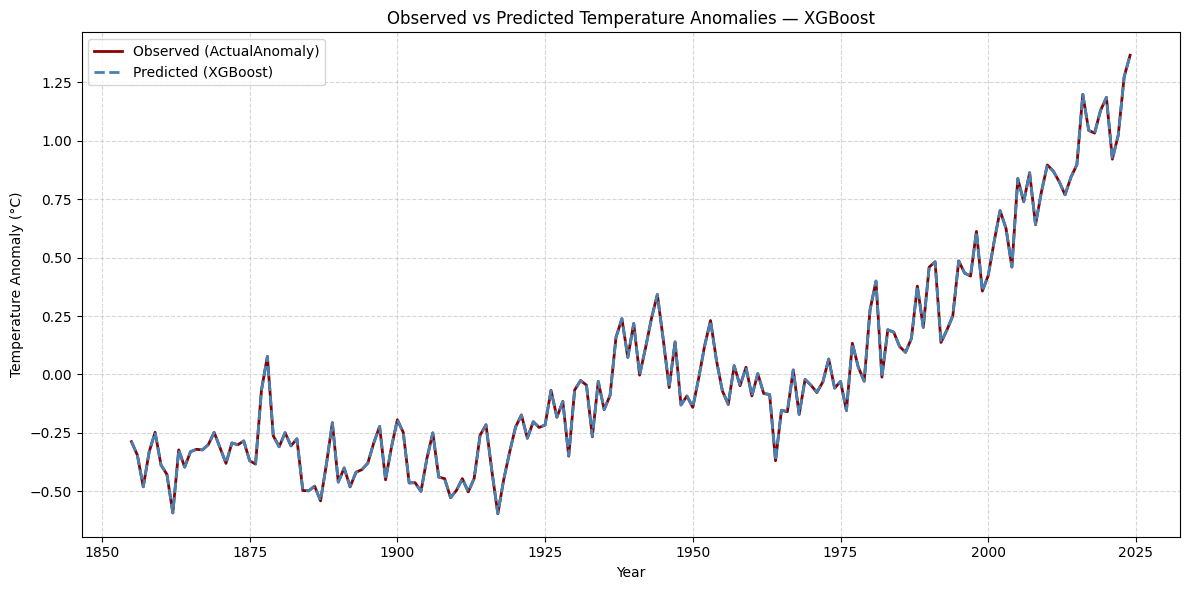

In [8]:
# Group to annual means for a clean comparison
compare_df = merged_df.groupby("Year")[["ActualAnomaly", best_model_col]].mean().reset_index()

plt.figure(figsize=(12, 6))

# Actual observed anomalies
plt.plot(
    compare_df["Year"],
    compare_df["ActualAnomaly"],
    label="Observed (ActualAnomaly)",
    color="darkred",
    linewidth=2
)

# Best model predictions
plt.plot(
    compare_df["Year"],
    compare_df[best_model_col],
    label=f"Predicted ({best_model})",
    color="steelblue",
    linewidth=2,
    linestyle="--"
)

# Formatting
plt.title(f"Observed vs Predicted Temperature Anomalies — {best_model}")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This step compares the actual recorded temperature anomalies with the predictions from the best‑performing model, averaged to one value per year for a clean, noise‑free view. The chart plots two lines over time: a solid dark red line for observed anomalies and a dashed steel blue line for the model’s predictions. Both follow a similar upward trend from the mid‑19th century to the present, with especially steep increases after 2000, showing the model captures the long‑term warming signal well. Close alignment between the lines indicates strong predictive accuracy, while any visible gaps highlight periods where the model slightly over‑ or under‑estimated actual values. This visual serves as a straightforward check on how faithfully the model reproduces the historical climate anomaly record.
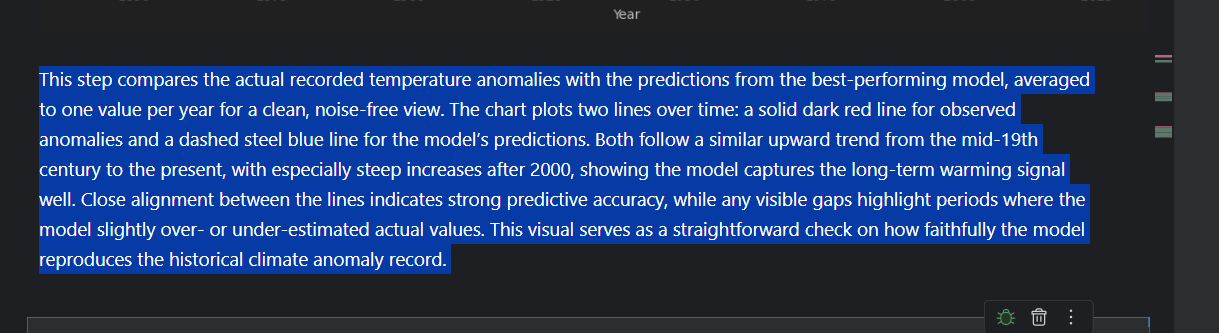

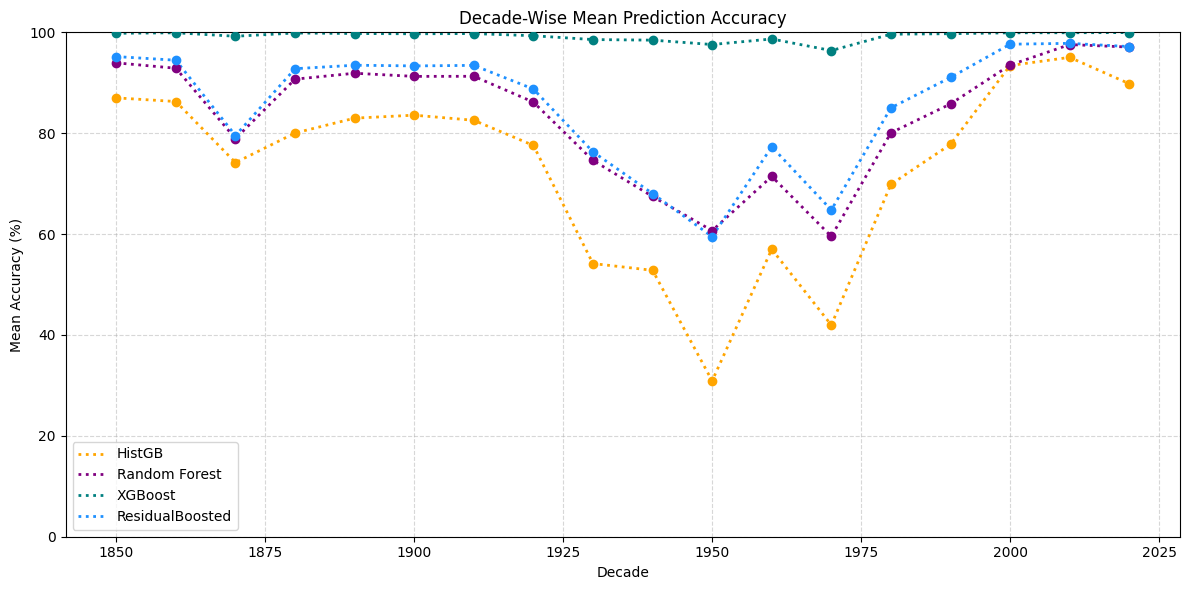


=== Decade-Wise Accuracy Summary ===
Best Decade: 2020 (XGBoost) → 99.96%
Worst Decade: 1950 (HistGB) → 30.90%
Overall Average Model Accuracy: 85.47%
Best Accuracy Achieved: 99.96% (XGBoost)


In [9]:
plt.figure(figsize=(12, 6))

# Track best/worst decade info
best_decade_info = None
worst_decade_info = None
best_acc_val = -np.inf
worst_acc_val = np.inf

for col, label in summary_models.items():
    df = merged_df.copy()
    df["Accuracy"] = compute_accuracy(df[col], df["ActualAnomaly"])
    grouped = df.groupby("Decade")["Accuracy"].mean().reset_index()

    # Plot lines
    plt.plot(
        grouped["Decade"], grouped["Accuracy"],
        linestyle=":", linewidth=2,
        color=colors.get(label, "gray"),
        label=label
    )
    plt.scatter(
        grouped["Decade"], grouped["Accuracy"],
        color=colors.get(label, "gray"), zorder=5
    )

    # Check for best/worst decade
    for _, row in grouped.iterrows():
        if row["Accuracy"] > best_acc_val:
            best_acc_val = row["Accuracy"]
            best_decade_info = (int(row["Decade"]), label)
        if row["Accuracy"] < worst_acc_val:
            worst_acc_val = row["Accuracy"]
            worst_decade_info = (int(row["Decade"]), label)

# Compute overall average accuracy across all models/decades
all_acc_values = []
for col in summary_models.keys():
    df = merged_df.copy()
    df["Accuracy"] = compute_accuracy(df[col], df["ActualAnomaly"])
    all_acc_values.extend(df.groupby("Decade")["Accuracy"].mean().values)

overall_avg_acc = np.mean(all_acc_values)

# Final formatting
plt.title("Decade-Wise Mean Prediction Accuracy")
plt.xlabel("Decade")
plt.ylabel("Mean Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === Print stats below the graph ===
print("\n=== Decade-Wise Accuracy Summary ===")
print(f"Best Decade: {best_decade_info[0]} ({best_decade_info[1]}) → \033[92m{best_acc_val:.2f}%\033[0m")
print(f"Worst Decade: {worst_decade_info[0]} ({worst_decade_info[1]}) → \033[91m{worst_acc_val:.2f}%\033[0m")
print(f"Overall Average Model Accuracy: {overall_avg_acc:.2f}%")
print(f"Best Accuracy Achieved: \033[92m{best_acc_val:.2f}%\033[0m ({best_decade_info[1]})")


This section plots decade‑wise mean prediction accuracy for all models, calculating average accuracy per decade, overlaying dotted lines for each, and tracking the single best and worst decade across the entire time span. The graph shows that performance varies over time, with XGBoost peaking at near‑perfect accuracy in the 2020s and HistGradientBoosting hitting its lowest point in the 1950s. Most models remain relatively stable in the latter half of the 20th century, while earlier decades show greater fluctuation, likely due to sparse and less reliable historical data. In recent decades, the model lines converge, suggesting modern records enable more consistent performance. In contrast, divergence in earlier periods highlights differences in how each model handles limited or noisy inputs.